Shape: (14640, 15)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 1464

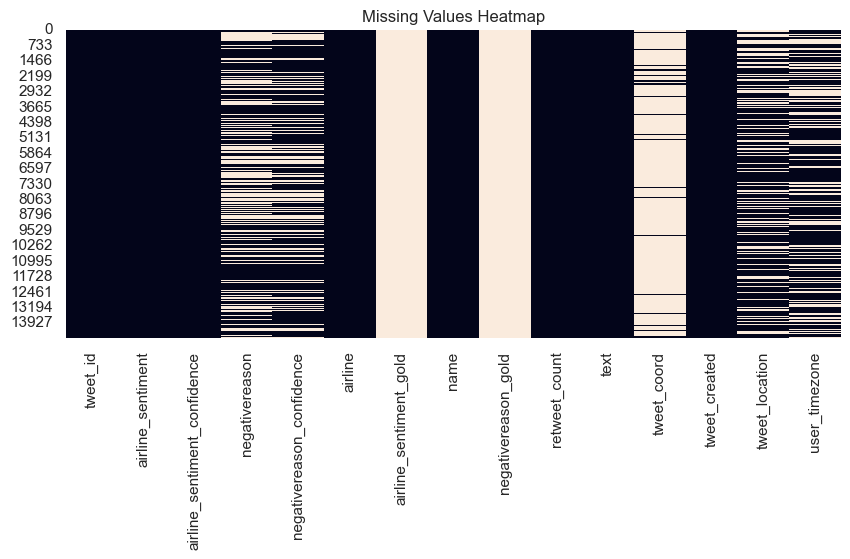

Duplicate rows: 38
Shape after removing duplicates: (14602, 15)
Outliers detected: {'negativereason_confidence': 6556, 'retweet_count': 766}


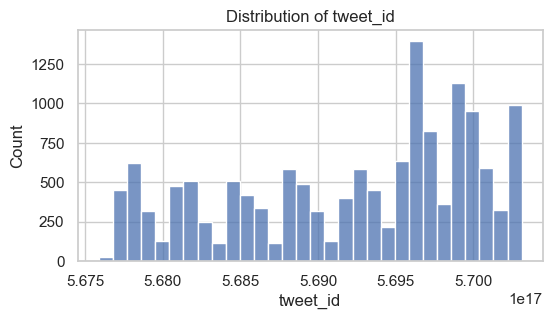

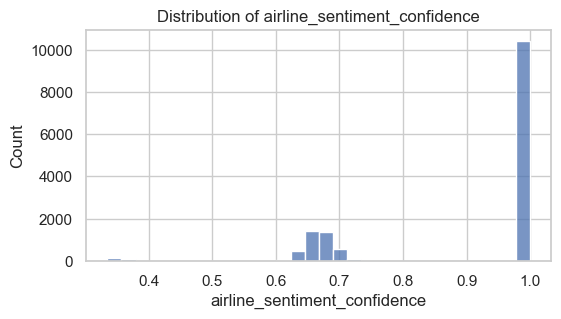

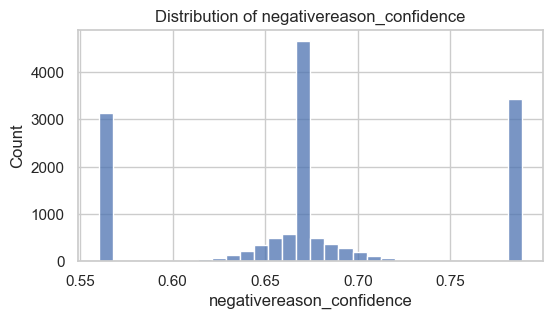

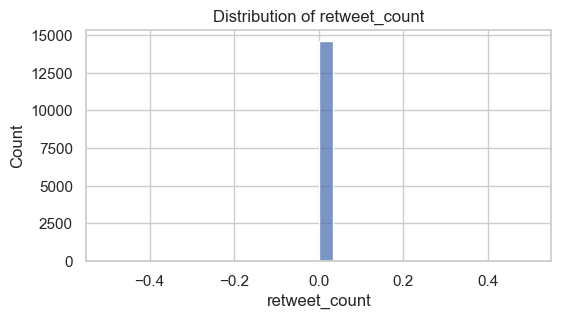

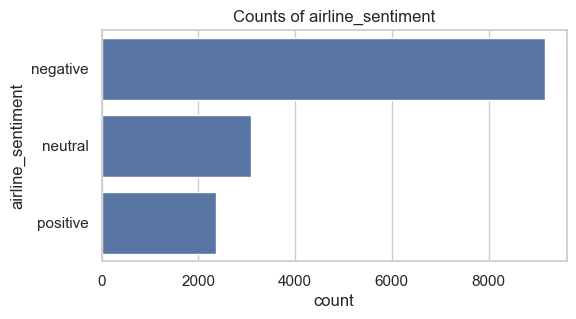

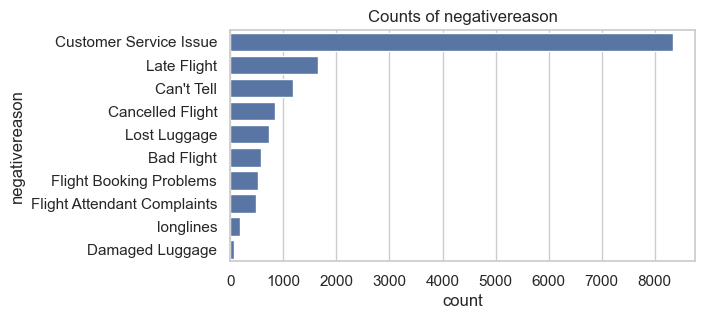

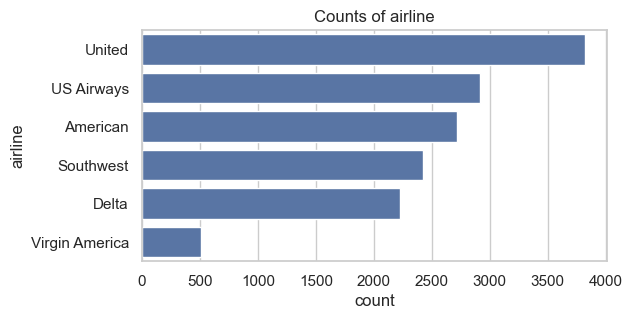

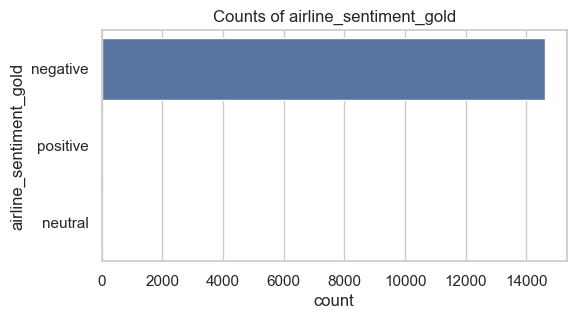

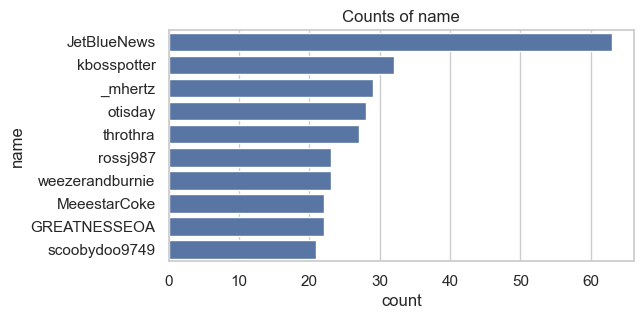

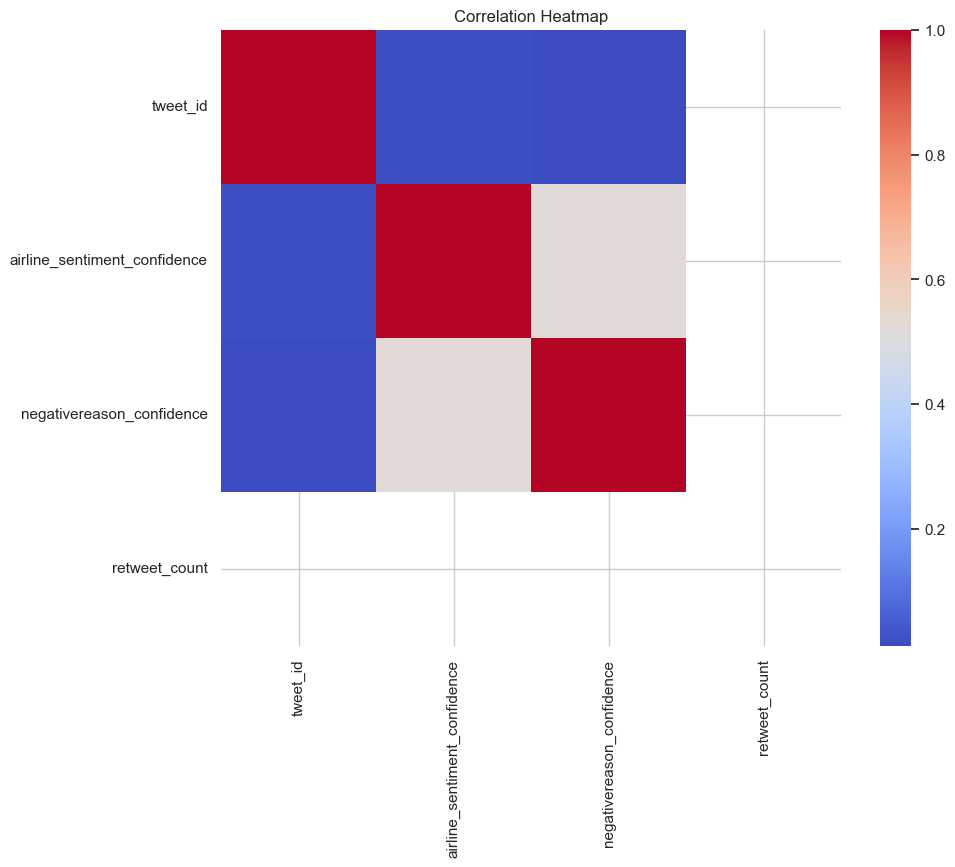

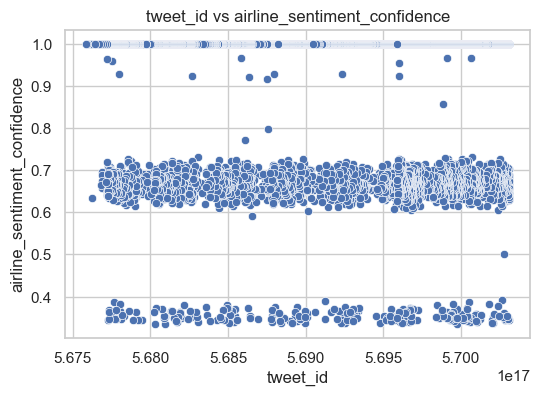

KeyboardInterrupt: 

In [2]:
# 1) Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

# 2) Load dataset
df = pd.read_csv("Tweets.csv")
print("Shape:", df.shape)

# 3) Data inspection
print("\nInfo:")
print(df.info())
print("\nHead:")
print(df.head())
print("\nDescribe (numeric):")
print(df.describe())
print("\nDescribe (categorical):")
print(df.describe(include=['object']))


# 4) Missing values
print("\nMissing values:")
print(df.isnull().sum())

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Example imputation:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# 5) Duplicates
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

# 6) Outlier detection (IQR method)
def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

outlier_counts = {}
for col in num_cols:
    outliers = detect_outliers_iqr(df[col])
    if len(outliers) > 0:
        outlier_counts[col] = len(outliers)

print("Outliers detected:", outlier_counts)

# Option: clip outliers
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

# 7) Univariate analysis
# Numeric distributions
for col in num_cols[:5]:  # first 5 numeric columns
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(f"Distribution of {col}")
    plt.show()

# Categorical counts
for col in cat_cols[:5]:  # first 5 categorical columns
    plt.figure(figsize=(6,3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10])
    plt.title(f"Counts of {col}")
    plt.show()

# 8) Bivariate / Multivariate analysis
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatterplot example
if len(num_cols) >= 2:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[num_cols[0]], y=df[num_cols[1]])
    plt.title(f"{num_cols[0]} vs {num_cols[1]}")
    plt.show()

# 9) Encoding categorical features
# Label encoding
le = LabelEncoder()
for col in cat_cols:
    df[col+"_enc"] = le.fit_transform(df[col].astype(str))

# One-hot encoding (for low-cardinality categorical variables)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 10) Feature scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Alternative:
# mms = MinMaxScaler()
# df[num_cols] = mms.fit_transform(df[num_cols])

# 11) Handling class imbalance (if target exists)
target_col = "target"  # change this to actual target column
if target_col in df.columns:
    print("Class distribution before:", df[target_col].value_counts())

    # Upsample minority classes
    dfs = []
    max_size = df[target_col].value_counts().max()
    for cls in df[target_col].unique():
        subset = df[df[target_col] == cls]
        if len(subset) < max_size:
            subset = resample(subset, replace=True, n_samples=max_size, random_state=42)
        dfs.append(subset)
    df = pd.concat(dfs)

    print("Class distribution after:", df[target_col].value_counts())

# 12) Feature selection
if target_col in df.columns:
    corr_matrix = df.corr()
    corr_with_target = corr_matrix[target_col].abs().sort_values(ascending=False)
    selected_features = corr_with_target[corr_with_target >= 0.65].index.tolist()
    print("Selected features (corr ≥ 0.65):", selected_features)

# Alternative method: Mutual Information
if target_col in df.columns:
    X = df.drop(columns=[target_col])
    y = df[target_col]
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y.astype(str))
    mi = mutual_info_classif(X.select_dtypes(include=[np.number]).fillna(0), y)
    mi_series = pd.Series(mi, index=X.select_dtypes(include=[np.number]).columns).sort_values(ascending=False)
    print("Top features (Mutual Info):")
    print(mi_series.head(10))

# 13) Save cleaned dataset
df.to_csv("cleaned_data.csv", index=False)
print("Final dataset saved as cleaned_data.csv")


In [3]:
cleaned = pd.read_csv('cleaned_data.csv')
print(cleaned.head())

KeyboardInterrupt: 